# Create a diagram illustrating attract mode movement

## Helper functions

In [31]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
from well_graphs import create3DVertices,makeFullGraph,create2DVertices
import os

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

In [30]:
def parse_vector_data(data):
    arrays = []
    vals = []
    for l in data.splitlines()[1:]:
        if not l.strip():
            arrays += [(nm,vals)]
            vals = []
            continue
        if ';' in l:
            nm = l.split(';')[1].strip()
        dt = [x for x in l.split(' ') if x][1]
        ls = [var_map[x] if x in var_map else int(x,16) for x in dt.split(',')]
        vals += ls
    return arrays


In [148]:
def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
    return vecs


In [33]:
def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def vectors_to_xycoords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys=[],[]
    px,py=0,0
    for x,y,_ in vectors:
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
    return list(zip(xs,ys))



In [34]:
def plot_vertices(verts,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box') 
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)


In [89]:
def setObjectVertices(xys, scale=1, zpos=0, color="blue", xoffset=0, yoffset=0,
                    inverty=True, invertx=False):
    """
    Takes a list of (x.y) tuples and converts into a 3d np-array at the selected zpos.
    """
    max_x = max(x for x,_ in xys)
    max_y = max(y for _,y in xys)
    i = 0
    vertices = []
    for x,y in xys:
        x = max_x - x if invertx else x
        x += xoffset
        # invert the y values so right side up
        y = max_y - y if inverty else y
        y += yoffset
        vertices += [(x*scale,y*scale,zpos)]
    y = np.array([y for _,y,_ in vertices])
    x = np.array([x for x,_,_ in vertices])
    z = np.array([[z for _,_,z in vertices]])
    return (x,y,z)

In [129]:
AZIMUTH=135
ELEVATION = 20

def makeWebAndClawDiagram(web_vertices, objects_vertices,filename="default.png"):
    #Change the Size of Graph using Figsize
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    plt.rcParams['grid.color'] = "navy"
    # Make sure the plot starts at zero in all dimensions
    ax.plot_wireframe(np.zeros((1,2)), np.zeros((1,2)), np.zeros((1,2)), color ='black')
    
    # Plot the claw
    for (object_vertices,color) in objects_vertices:
        x,y,z = object_vertices
        ax.plot_wireframe(x,y,z,color=color)

    # Plot the web.
    x,y,z = web_vertices
    ax.plot_wireframe(x, y, z, color ='blue')
    #Rotate the web.
    ax.view_init(azim=AZIMUTH,elev=ELEVATION,vertical_axis="y")
    # Set the background colors
    ax.xaxis.set_pane_color("black")
    ax.yaxis.set_pane_color("black")
    ax.zaxis.set_pane_color("black")

    # Save the image.
    plt.savefig(filename, transparent=True,bbox_inches='tight')
    return

## Create the Web Data

In [35]:
from varmap import var_map
x_data = """
  .BYTE DG0,DG225,DG450,DG675,DG900  ;CIRCLE
  .BYTE -DG675,-DG450,-DG225,-DG0
  .BYTE -DG225,-DG450,-DG675
  .BYTE DG900,DG675,DG450,DG225
    
  .BYTE 10,1E,2D,3C,4B,5A,69,78,87  ;PLANE
  .BYTE 96,0A5,0B4,0C3,0D2,0E1,0F0
    
"""
y_data = """
  .BYTE DG900,DG675,DG450,DG225,DG0  ;CIRCLE
  .BYTE DG225,DG450,DG675,DG900
  .BYTE -DG675,-DG450,-DG225,-DG0
  .BYTE -DG225,-DG450,-DG675
  
  .BYTE 40,40,40,40,40,40,40,40 ;PLANE
  .BYTE 40,40,40,40,40,40,40,40
    
"""
"""
HOLRAP:	
    .BYTE 0,0,0,0,0,0,0,-1,-1,-1,-1,0,0,-1,0,-1	;PLANAR(-1)/CLOSED(0) FLAG
"""
# tells us whether the well is open or closed.
closed = [0,-1]

In [57]:
x_vecs = parse_vector_data(x_data)
y_vecs = parse_vector_data(y_data)

webs_vertices = []
for i in range(0,len(x_vecs)):
    xnm,xs = x_vecs[i]
    ynm,ys = y_vecs[i]
    planar = closed[i]
    vertices = list(zip(xs,ys))
    x,y,z = create3DVertices(vertices,planar)
    webs_vertices += [(x,y,z)]
    #makeFullGraph(x,y,z, f"attract_mode_movement/{xnm}_3d.png")
circle_web_vertices = webs_vertices[0]
plane_web_vertices = webs_vertices[1]

### Cursor data

In [41]:
vector_data = """
NCRS6S:
	VEC 6,-2
	VEC 2,2
	VEC -3,1
	VEC 2,-1
	VEC -1,-1
	VEC -5,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
claw_data = vectors_to_xycoords(vectors)
claw_data

[(0, 0), (6, -2), (8, 0), (5, 1), (7, 0), (6, -1), (1, 0), (3, 1), (0, 0)]

### Flipper data

In [94]:
vector_data = """
INVA1S:
	VEC 4,1,1
	VEC 4,-1,1
	VEC -2,1
	VEC 1,1
	VEC -3,-1
	VEC -3,1
	VEC 1,-1
	VEC -2,-1
"""
vectors = parse_vector_commands(vector_data,default_color="red")
flipper_data = vectors_to_xycoords(vectors)
flipper_data

[(0, 0), (4, 1), (8, 0), (6, 1), (7, 2), (4, 1), (1, 2), (2, 1), (0, 0)]

### Before movement - on plane web

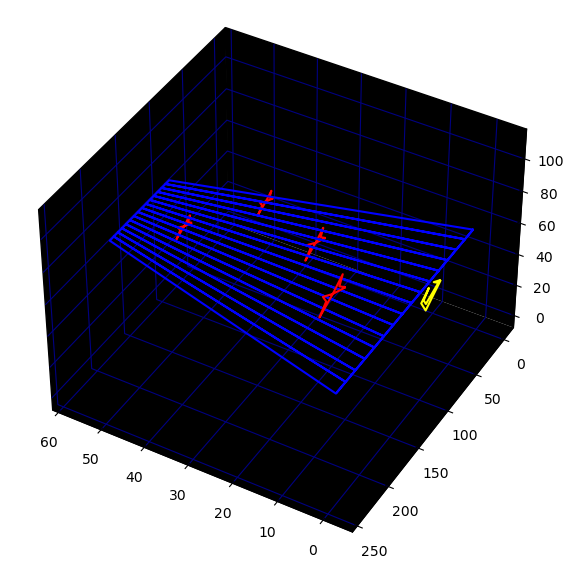

In [192]:
AZIMUTH=120
ELEVATION = 40
objects_vertices = []
claw_vertices = setObjectVertices(claw_data, scale=4, zpos=-5,
                                xoffset=28, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(claw_vertices,"yellow")]

flipper_vertices = setObjectVertices(flipper_data, scale=3, zpos=40,
                                xoffset=18, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=4, zpos=20,
                                xoffset=28, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=3, zpos=50,
                                xoffset=38, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=5, zpos=5,
                                xoffset=38, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

makeWebAndClawDiagram(plane_web_vertices, objects_vertices,
                      filename=f"attract_mode_movement/movement_example1_before.png")
    

### After movement - on plane web

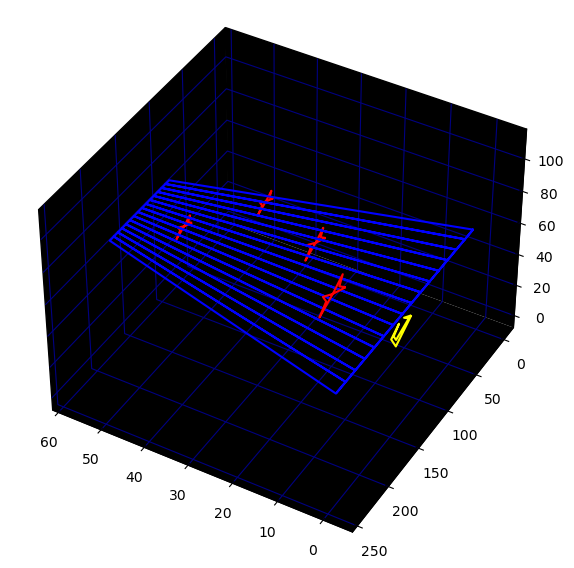

In [195]:
AZIMUTH=120
ELEVATION = 40
objects_vertices = []
claw_vertices = setObjectVertices(claw_data, scale=4, zpos=-5,
                                xoffset=40, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(claw_vertices,"yellow")]

flipper_vertices = setObjectVertices(flipper_data, scale=3, zpos=40,
                                xoffset=18, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=4, zpos=20,
                                xoffset=28, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=3, zpos=50,
                                xoffset=38, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=5, zpos=5,
                                xoffset=38, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

makeWebAndClawDiagram(plane_web_vertices, objects_vertices,
                      filename=f"attract_mode_movement/movement_example1_after.png")
    

### Player Charge - vector data

In [151]:
vector_data = """
DIARA2:	
    ICVEC
	CSTAT BLUE
	SCDOT 0,0
	SCDOT 7,0
	SCDOT 5,5
	SCDOT 0,7
	SCDOT -5,5
	SCDOT -7,0
	SCDOT -5,-5
	SCDOT 0,-7
	SCDOT 5,-5
	CSTAT YELLOW
	SCDOT 0F,0
	SCDOT 0B,0B
	SCDOT 0,0F
	SCDOT -0B,0B
	SCDOT -0B,0
	SCDOT -0B,-0B
	SCDOT 0,-0B
	SCDOT 0B,-0B
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
charge_data = vectors_to_xycoords(vectors)


### Player Charge - Shooting Example

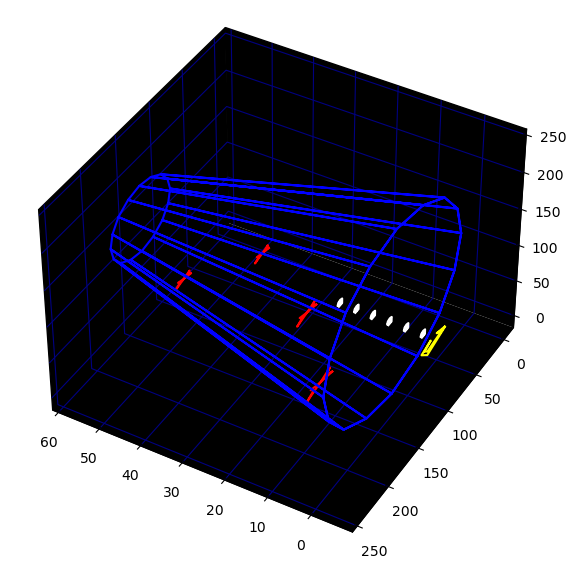

In [207]:
AZIMUTH=120
ELEVATION = 40
objects_vertices = []
claw_vertices = setObjectVertices(claw_data, scale=5, zpos=-8,
                                xoffset=20, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(claw_vertices,"yellow")]

flipper_vertices = setObjectVertices(flipper_data, scale=3, zpos=40,
                                xoffset=18, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=4, zpos=20,
                                xoffset=28, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=3, zpos=50,
                                xoffset=38, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

flipper_vertices = setObjectVertices(flipper_data, scale=5, zpos=5,
                                xoffset=38, yoffset=20, color="yellow", inverty=False)
objects_vertices += [(flipper_vertices,"red")]

for z in range(4,28,4):
    charge_vertices = setObjectVertices(charge_data, scale=0.3, zpos=z,
                                    xoffset=150, yoffset=20, color="yellow", inverty=False)
    objects_vertices += [(charge_vertices,"white")]

makeWebAndClawDiagram(circle_web_vertices, objects_vertices,
                      filename=f"attract_mode_movement/shooting_between.png")
    

In [191]:
hex(0x81 ^ 0xff)

'0x7e'